In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

(1) Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.
Now how do you detect face and eyes?

In [2]:
img = cv2.imread('test_img/rohit-sharma-4.jpg')
img.shape

(750, 900, 3)

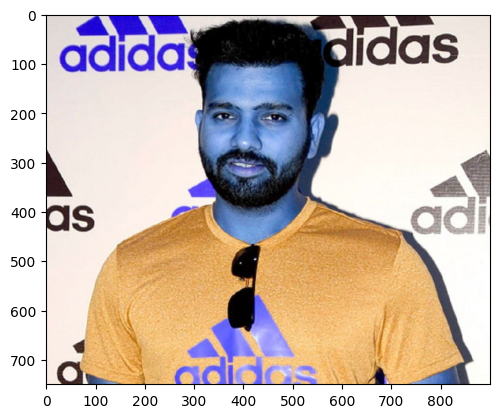

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(750, 900)

In [5]:
gray

array([[214, 214, 214, ..., 224, 224, 224],
       [213, 213, 213, ..., 225, 225, 225],
       [212, 212, 213, ..., 226, 226, 226],
       ...,
       [235, 235, 235, ..., 253, 253, 253],
       [236, 236, 236, ..., 253, 253, 253],
       [236, 236, 236, ..., 253, 253, 253]], dtype=uint8)

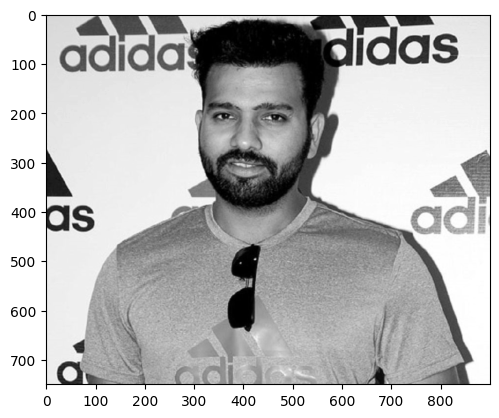

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[266,  92, 287, 287]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(266, 92, 287, 287)

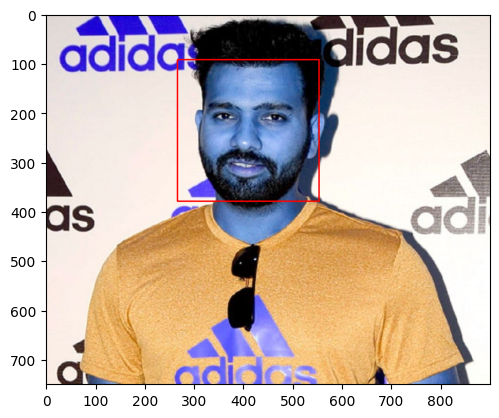

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

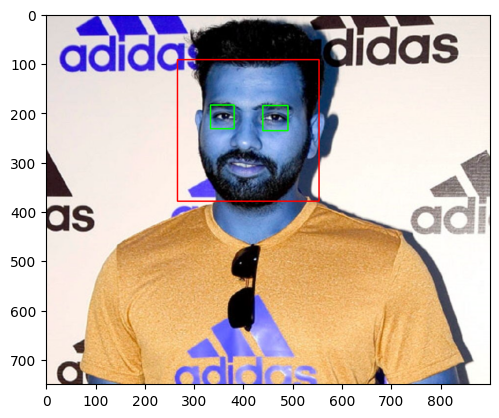

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()


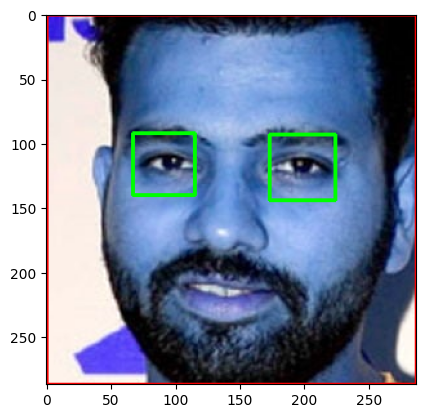

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(287, 287, 3)

(3) Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
Wavelet transform

In [13]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


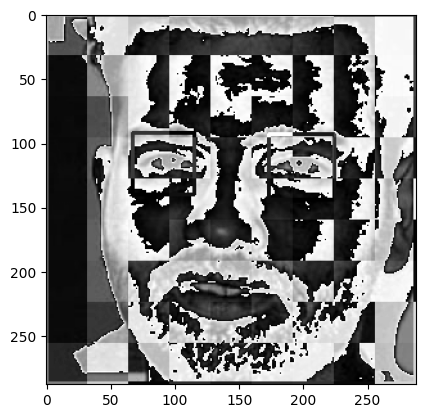

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier
(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region
Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

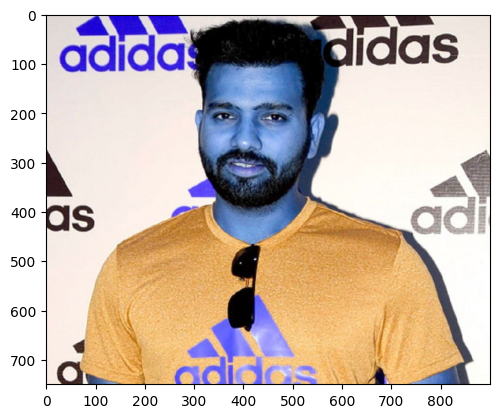

In [16]:
original_image = cv2.imread('test_img/rohit-sharma-4.jpg')
plt.imshow(original_image)

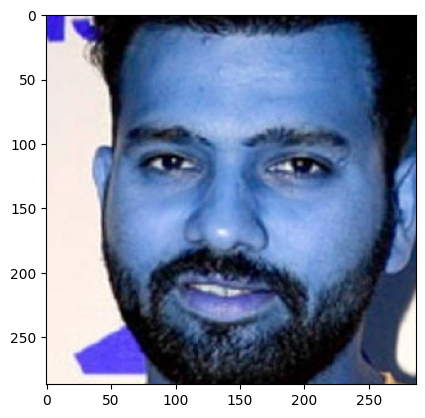

In [17]:
cropped_image = get_cropped_image_if_2_eyes('test_img/rohit-sharma-4.jpg')
plt.imshow(cropped_image)

in below image face is not very clear and it doesn't have two eyes clearly visible

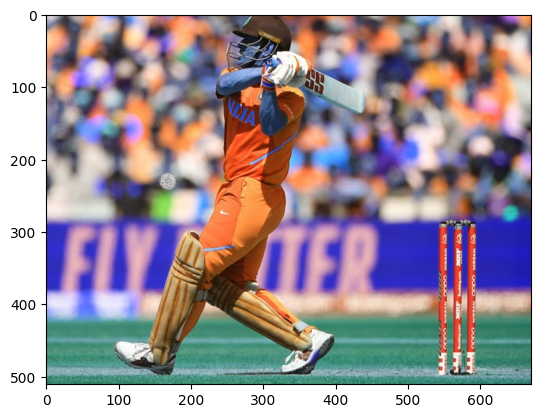

In [18]:
org_image_obstructed = cv2.imread('test_img/27dhoni-50.jpg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('test_img/27dhoni-50.jpg')
cropped_image_no_2_eyes

In [20]:
path_to_data = "./image data set/"
path_to_cr_data = "./image data set/cropped/"

In [21]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [22]:
img_dirs

['./image data set/cropped',
 './image data set/harshad_mahta',
 './image data set/kiara_advani',
 './image data set/lionel_messi',
 './image data set/ms_dhoni',
 './image data set/rohit_sharma',
 './image data set/sachin_tendulkar',
 './image data set/virat_kohli']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [23]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        if entry.name.endswith('.png') or entry.name.endswith('.jpg') or entry.name.endswith('.jpeg'):
            try:
                roi_color = get_cropped_image_if_2_eyes(entry.path)
            except:
                print("Error processing image:", entry.path)
                continue
            if roi_color is not None:
                cropped_folder = path_to_cr_data + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                cropped_file_name = celebrity_name + str(count) + ".png"
                cropped_file_path = cropped_folder + "/" + cropped_file_name
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1
        else:
            print("Skipping file:", entry.path)

Generating cropped images in folder:  ./image data set/cropped/harshad_mahta
Generating cropped images in folder:  ./image data set/cropped/kiara_advani
Skipping file: ./image data set/kiara_advani\kiaraadvani11612100603.webp
Skipping file: ./image data set/kiara_advani\kiaraadvani21593576940.webp
Skipping file: ./image data set/kiara_advani\kiaraadvani21606907531.webp
Skipping file: ./image data set/kiara_advani\kiaraadvani91561209177.webp
Generating cropped images in folder:  ./image data set/cropped/lionel_messi
Skipping file: ./image data set/lionel_messi\5e4bac9b3b62b77617608663.jfif
Skipping file: ./image data set/lionel_messi\85054-messi12.jfif
Skipping file: ./image data set/lionel_messi\crop.jfif
Skipping file: ./image data set/lionel_messi\download.jfif
Skipping file: ./image data set/lionel_messi\images.jfif
Skipping file: ./image data set/lionel_messi\Lionel.Messi_.webp
Generating cropped images in folder:  ./image data set/cropped/ms_dhoni
Skipping file: ./image data set/m

Now you should have cropped folder under datasets folder that contains cropped images
Manually examine cropped folder and delete any unwanted images

In [25]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'cropped': 0,
 'harshad_mahta': 1,
 'kiara_advani': 2,
 'lionel_messi': 3,
 'ms_dhoni': 4,
 'rohit_sharma': 5,
 'sachin_tendulkar': 6,
 'virat_kohli': 7}

images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [26]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [27]:
len(X[0])

4096

In [28]:
X[0]

array([[ 12],
       [ 13],
       [ 23],
       ...,
       [192],
       [200],
       [ 22]], dtype=uint8)

In [29]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(519, 4096)

Data cleaning process is done. Now we are ready to train our model
We will use SVM with rbf kernel tuned with heuristic finetuning

In [30]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7153846153846154

In [32]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.71      0.89      0.79        28
           3       1.00      0.33      0.50        12
           4       0.63      0.77      0.69        22
           5       0.73      0.96      0.83        47
           6       0.00      0.00      0.00         4
           7       1.00      0.09      0.17        11

    accuracy                           0.72       130
   macro avg       0.72      0.46      0.47       130
weighted avg       0.75      0.72      0.66       130



c:\python projects\celebilityfacedictuction\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python projects\celebilityfacedictuction\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python projects\celebilityfacedictuction\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Let's use GridSearch to try out different models with different paramets.
Goal is to come up with best modle with best fine tuned parameters

In [59]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [60]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [61]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,

        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.781419,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.678488,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.773593,{'logisticregression__C': 5}


In [62]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [63]:
best_estimators['svm'].score(X_test,y_test)

0.7692307692307693

In [64]:
best_estimators['random_forest'].score(X_test,y_test)

0.676923076923077

In [65]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7923076923076923

In [66]:
best_clf = best_estimators['svm']

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  0,  0,  2,  0,  0,  0],
       [ 0, 26,  0,  1,  0,  0,  1],
       [ 0,  2,  7,  0,  2,  0,  1],
       [ 0,  3,  2, 14,  3,  0,  0],
       [ 0,  1,  0,  1, 44,  0,  1],
       [ 0,  2,  0,  1,  1,  0,  0],
       [ 0,  1,  0,  0,  5,  0,  5]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

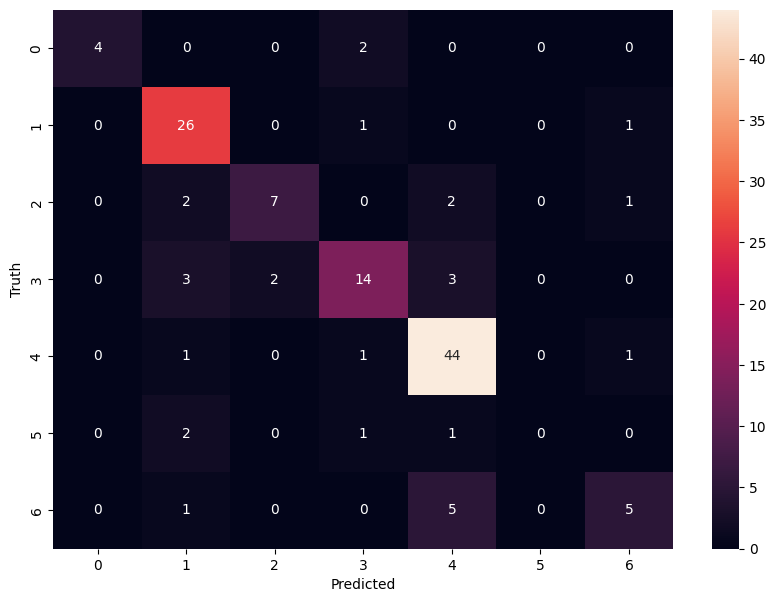

In [68]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [69]:
class_dict

{'cropped': 0,
 'harshad_mahta': 1,
 'kiara_advani': 2,
 'lionel_messi': 3,
 'ms_dhoni': 4,
 'rohit_sharma': 5,
 'sachin_tendulkar': 6,
 'virat_kohli': 7}

In [70]:
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [71]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [58]:
cm

array([[ 4,  0,  0,  2,  0,  0,  0],
       [ 0, 26,  0,  1,  0,  0,  1],
       [ 0,  2,  7,  0,  2,  0,  1],
       [ 0,  3,  2, 14,  3,  0,  0],
       [ 0,  1,  0,  1, 44,  0,  1],
       [ 0,  2,  0,  1,  1,  0,  0],
       [ 0,  1,  0,  0,  5,  0,  5]], dtype=int64)